In [1]:
%pylab inline
from pandas import *
import pickle

Populating the interactive namespace from numpy and matplotlib


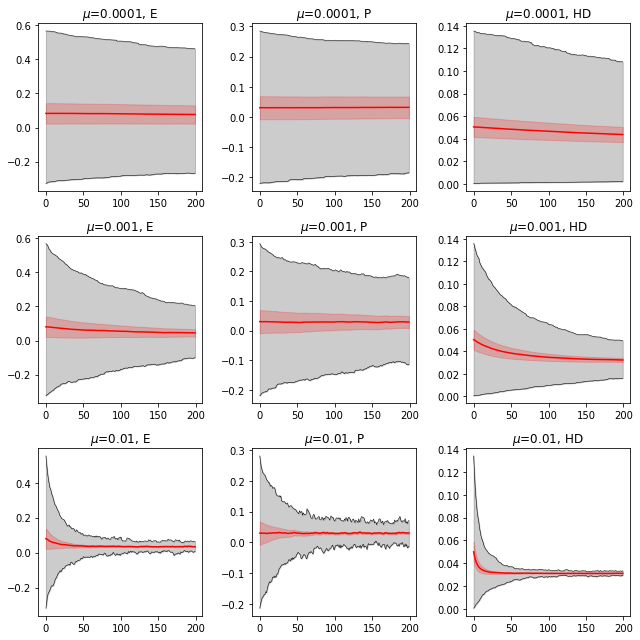

In [20]:
# C.I driftCollector
import numpy as np
import matplotlib.pyplot as plt
import pickle

driftCollector = pickle.load(open("driftCollector.p", "rb"))

plt.figure(figsize=(9, 9))
where = 1
name = ["E", "P", "HD"]

for my in [0.0001, 0.001, 0.01]:
    for who in range(3):
        plt.subplot(3, 3, where)
        D = np.array(driftCollector[f"{my} {name[who]}"])  # shape: (reps, time)

        Dmin = D.min(0)
        Dmax = D.max(0)
        Dmean = D.mean(0)

        # Compute 95% CI
        stderr = D.std(0, ddof=1) / np.sqrt(D.shape[0])
        ci_upper = Dmean + 1.96 * stderr
        ci_lower = Dmean - 1.96 * stderr

        # Plot drift envelope
        plt.fill_between(range(D.shape[1]), Dmin, Dmax, color='k', alpha=0.2)
        plt.plot(Dmax, 'k', linewidth=0.5)
        plt.plot(Dmin, 'k', linewidth=0.5)

        # Plot mean line and its confidence interval
        plt.fill_between(range(D.shape[1]), ci_lower, ci_upper, color='red', alpha=0.2)  # CI shadow
        plt.plot(Dmean, color='red', linewidth=1.5)  # Mean line

        plt.title(f"$\\mu$={my}, {name[who]}")
        where += 1

plt.tight_layout()
plt.show()


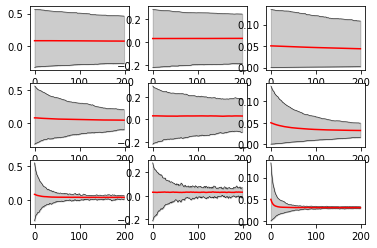

In [2]:
driftCollector=pickle.load(open("driftCollector.p","rb"))
where=1
name=["E","P","HD"]
for my in [0.0001,0.001,0.01]:
    for who in range(3):
        subplot(3,3,where)
        D=driftCollector["{0} {1}".format(my,name[who])]
        D=numpy.array(D)
        Dmin=D.min(0)
        Dmax=D.max(0)
        fill_between(range(200),Dmin,Dmax,color='k',alpha=0.2)
        plot(Dmax,'k',linewidth=0.5)
        plot(Dmin,'k',linewidth=0.5)
        plot(D.mean(0),'r')
        where+=1

In [5]:
def myEval(S):
    s=S.replace("]","").replace("[","")
    R=[]
    for e in s.split(","):
        R.append(float(e))
    return R

def myEval2D(S):
    M=[]
    s=S.replace("[[","").replace("]]","")
    for E in s.split("],["):
        R=[]
        for e in E.split(","):
            R.append(float(e))
        M.append(R)
    return M

In [3]:
def rolling_average(data, window_size):
    if window_size < 1:
        raise ValueError("window_size must be at least 1")

    # Calculate padding size
    pad_size = window_size // 2

    # Pad the data at both ends with repeated boundary values
    padded_data = np.pad(data, pad_width=pad_size, mode='edge')

    # Calculate the rolling average using a uniform filter
    rolling_avg = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')

    return rolling_avg

def step_function_expand(lists, target_length):
    expanded_lists = []
    
    for lst in lists:
        current_length = len(lst)
        
        # Generate the original x-axis values based on the current length
        x_original = np.linspace(0, 1, current_length, endpoint=False)
        
        # Generate the new x-axis values for the target length
        x_target = np.linspace(0, 1, target_length, endpoint=False)
        
        # Create a list to store the expanded values
        expanded_list = []
        
        # Use step function to repeat each value until the next one
        for i in range(current_length - 1):
            start = x_original[i]
            end = x_original[i + 1]
            count = np.sum((x_target >= start) & (x_target < end))
            expanded_list.extend([lst[i]] * count)
        
        # Handle the last segment separately (from last original x to the end)
        count = np.sum(x_target >= x_original[-1])
        expanded_list.extend([lst[-1]] * count)
        
        expanded_lists.append(expanded_list)
    
    return expanded_lists

#L=step_function_expand(E[0],5000)
#plot(rolling_average(numpy.array(L).mean(0),10))

In [6]:
collector=dict()
Mys=[0.0001,0.001,0.01]
Ks=[1,3,5,7]
for K in Ks:
    for my in Mys:
        E=[]
        P=[]
        HD=[]
        for i in range(21):
            E.append([])
            P.append([])
            HD.append([])
        for rep in range(50):
            #for who in range(3):
            data=read_csv(r"C:\Users\pmh\NKEarlyData\dataAllStart.tar\dataAllStart\data_{0}_{1}_{2}.csv".format(K,my,rep))
            for i in range(len(data)):
                pos=data["dip0peak1"][i]
                dummy=myEval(data["LODe"][i])
                E[pos].append(dummy)
                dummy=myEval(data["LODp"][i])
                P[pos].append(dummy)
                dummy=myEval(data["LODhd"][i])
                HD[pos].append(dummy)
        collector["{0} {1}".format(K,my)]=[E,P,HD]
        
        

In [24]:
import numpy as np
from math import ceil
from statistics import mean

def step_function_expand(lists, target_length):
    expanded_lists = []
    for lst in lists:
        current_length = len(lst)
        if current_length < 2:
            expanded_lists.append([lst[0]] * target_length)
            continue
        x_original = np.linspace(0, 1, current_length, endpoint=False)
        x_target = np.linspace(0, 1, target_length, endpoint=False)
        expanded_list = []
        for i in range(current_length - 1):
            start = x_original[i]
            end = x_original[i + 1]
            count = np.sum((x_target >= start) & (x_target < end))
            expanded_list.extend([lst[i]] * count)
        count = np.sum(x_target >= x_original[-1])
        expanded_list.extend([lst[-1]] * count)
        expanded_lists.append(expanded_list)
    return expanded_lists

# Parameters
Mys = [0.0001, 0.001, 0.01]
Ks = [1, 3, 5, 7]
binWidth = 10
who = 1# Trait index: 0 = E, 1 = P, 2 = HD

collectorCI = dict()

for K in Ks:
    for my in Mys:
        M = collector[f"{K} {my}"][who]  # Get raw data for trait 'E'
        CI_per_condition = []

        for i in range(21):
            row_data = M[i]
            lengths = [len(rep) for rep in row_data if len(rep) > 1]
            if not lengths:
                CI_per_condition.append(None)
                continue

            target_length = int(ceil(mean(lengths)) * binWidth)
            expanded = step_function_expand(row_data, target_length)
            expanded = np.array(expanded)  # shape: (reps, time)

            # Bin into fixed time segments
            binned = expanded.reshape(expanded.shape[0], -1, binWidth).mean(axis=2)

            # Compute mean and CI at each bin
            mean_vals = binned.mean(axis=0)
            std_vals = binned.std(axis=0, ddof=1)
            se_vals = std_vals / np.sqrt(binned.shape[0])
            ci_lower = mean_vals - 1.96 * se_vals
            ci_upper = mean_vals + 1.96 * se_vals

            CI_per_condition.append({
                "mean": mean_vals,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper
            })

        collectorCI[f"{K} {my}"] = CI_per_condition


In [9]:
collectorShrunk=dict()
where=1
for my in Mys:
    for K in Ks:
        res=[]
        for who in range(3):
            M=collector["{0} {1}".format(K,my)][who]
            R=[]
            for i in range(21):
                L=[]
                for row in M[i]:
                    L.append(len(row))
                binWidth=10
                theLength=int(ceil(mean(L))*binWidth)
                Y=numpy.array(step_function_expand(M[i],theLength))
                Y=Y.mean(0)
                Y = Y.reshape(-1, 10).mean(axis=1)
                R.append(Y)
            res.append(R)
        collectorShrunk["{0} {1}".format(K,my)]=res

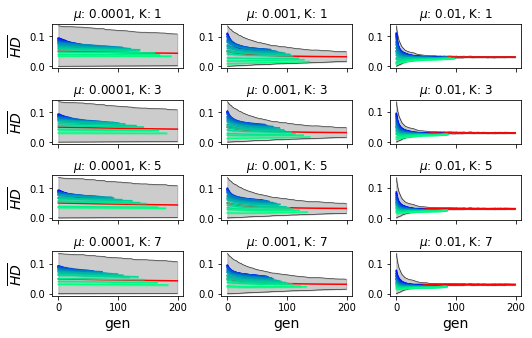

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
Mys = [0.0001, 0.001, 0.01]
Ks = [1, 3, 5, 7]
who = 2  # Trait: 0=E, 1=P, 2=HD
trait_name = ['E', 'P', 'HD'][who]

plt.figure(figsize=(7.5, 5))
where = 1
num_rows = 4
num_cols = 3
cmapWinter = plt.get_cmap('winter')

for row, K in enumerate(Ks):
    for col, my in enumerate(Mys):
        ax = plt.subplot(num_rows, num_cols, where)
        where += 1

        # Plot drift data
        D = np.array(driftCollector[f"{my} {trait_name}"])
        Dmin = D.min(0)
        Dmax = D.max(0)
        Dmean = D.mean(0)
        ax.fill_between(range(len(Dmin)), Dmin, Dmax, color='k', alpha=0.2)
        ax.plot(Dmax, 'k', linewidth=0.5)
        ax.plot(Dmin, 'k', linewidth=0.5)
        ax.plot(Dmean, 'r', label='Drift Mean')

        # Mean lines from collectorShrunk
        mean_lines = collectorShrunk[f"{K} {my}"][who]
        ci_data = collectorCI[f"{K} {my}"]

        colors = cmapWinter(np.linspace(0, 1, 21))
        for i in range(21):
            if ci_data[i] is None:
                continue
            mean_line = mean_lines[i]
            ci_lower = ci_data[i]["ci_lower"]
            ci_upper = ci_data[i]["ci_upper"]
            x = np.arange(len(mean_line))

            # Plot confidence interval and mean line
            ax.fill_between(x, ci_lower, ci_upper, color=colors[i], alpha=0.2)
            ax.plot(x, mean_line, color=colors[i])

        # Labels
        ax.set_title(f"$\\mu$: {my}, K: {K}", fontsize=12)
        if col == 0:
            ax.set_ylabel(r"$\overline{HD}$", fontsize=14)
        if row == num_rows - 1:
            ax.set_xlabel("gen", fontsize=14)
        else:
            ax.set_xticklabels([])

# Finalize layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{trait_name}_mean_CI_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()


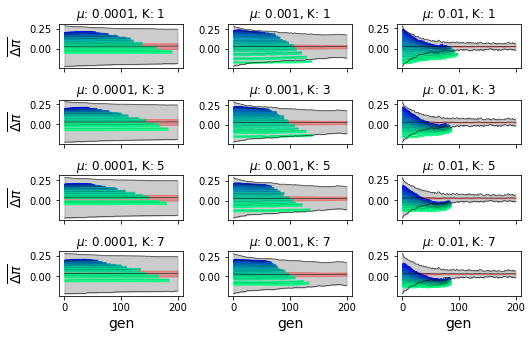

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
Mys = [0.0001, 0.001, 0.01]
Ks = [1, 3, 5, 7]
who = 1  # Trait: 0=E, 1=P, 2=HD
trait_name = ['E', 'P', 'HD'][who]

plt.figure(figsize=(7.5, 5))
where = 1
num_rows = 4
num_cols = 3
cmapWinter = plt.get_cmap('winter')

for row, K in enumerate(Ks):
    for col, my in enumerate(Mys):
        ax = plt.subplot(num_rows, num_cols, where)
        where += 1

        D = np.array(driftCollector[f"{my} {trait_name}"])
        Dmin = D.min(0)
        Dmax = D.max(0)
        Dmean = D.mean(0)

        # Compute 95% confidence interval for the drift
        stderr = D.std(0, ddof=1) / np.sqrt(D.shape[0])
        ci_upper = Dmean + 1.96 * stderr
        ci_lower = Dmean - 1.96 * stderr

        # Plot min/max envelope
        ax.fill_between(range(len(Dmin)), Dmin, Dmax, color='k', alpha=0.2)
        ax.plot(Dmax, 'k', linewidth=0.5)
        ax.plot(Dmin, 'k', linewidth=0.5)

        # Plot red CI and black mean line
        ax.fill_between(range(len(Dmean)), ci_lower, ci_upper, color='red', alpha=0.3)
        ax.plot(Dmean, 'k', label='Drift Mean', linewidth=0.5)


        # Mean lines and confidence intervals
        mean_lines = collectorShrunk[f"{K} {my}"][who]
        ci_data = collectorCI[f"{K} {my}"]

        colors = cmapWinter(np.linspace(0, 1, 21))

        # Plot CI shadows first
        for i in range(21):
            if ci_data[i] is None:
                continue
            mean_line = mean_lines[i]
            ci_lower = ci_data[i]["ci_lower"]
            ci_upper = ci_data[i]["ci_upper"]
            x = np.arange(len(mean_line))
            ax.fill_between(x, ci_lower, ci_upper, color=colors[i], alpha=0.85)

        # Then plot thin black lines on top
        for i in range(21):
            if ci_data[i] is None:
                continue
            mean_line = mean_lines[i]
            x = np.arange(len(mean_line))
            ax.plot(x, mean_line, color='black', linewidth=0.1)

        # Labels
        ax.set_title(f"$\\mu$: {my}, K: {K}", fontsize=12)
        if col == 0:
            ax.set_ylabel(r"$\overline{\Delta \pi}$", fontsize=14)
        if row == num_rows - 1:
            ax.set_xlabel("gen", fontsize=14)
        else:
            ax.set_xticklabels([])

# Final layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{trait_name}_mean_CI_plot_thinlines.pdf', dpi=300, bbox_inches='tight')
plt.show()
